In [1]:
# import pandas as pd
# import numpy as np
# import opsvis as opsv
# import openseespy.opensees as ops
# import csv
# import pathlib
from elastic_analysis import ElasticAnalysis
# from BuildingObject import Building_object

# def read_tworow_csv_file(file_path):
#     with open(file_path, 'r') as file:
#         reader = csv.DictReader(file)
#         data_dict = next(reader)  # 读取第一行的数据并转换为字典
#     return data_dict

# cwdFile = pathlib.Path.cwd()
# buildingDataFile = cwdFile / 'BuildingData'
# geometryFile = buildingDataFile / 'Geometry.csv'
# memberSizeFile = buildingDataFile / 'MemberSize.csv'
# loadsFile = buildingDataFile / 'Loads.csv'

# geometry = read_tworow_csv_file(geometryFile)
# member_size = pd.read_csv(memberSizeFile)
# gravity_loads = pd.read_csv(loadsFile)
# building = Building_object(geometry, member_size, gravity_loads)
import pandas as pd
import pathlib
from BuildingObject import Building_object
# from help_functions import read_tworow_csv_file

cwdFile = pathlib.Path.cwd()
buildingDataFile = cwdFile / 'BuildingData'
geometryFile = buildingDataFile / 'Geometry.csv'
memberSizeFile = buildingDataFile / 'MemberSize.csv'
loadsFile = buildingDataFile / 'Loads.csv'

# geometry = read_tworow_csv_file(geometryFile)
# for key in geometry.keys():
#     geometry[key] = int(geometry[key])
member_size = pd.read_csv(memberSizeFile)
gravity_loads = pd.read_csv(loadsFile)
directory = {}
dir_ElasticModel = cwdFile / 'BuildingElasticModel'
dir_BaselineElasticModel = cwdFile / 'BaselineTclFiles' / 'ElasticAnalysis'
directory = {'building elastic model': dir_ElasticModel,
             'baseline files elastic': dir_BaselineElasticModel,
             'building data': buildingDataFile}

# elf
building = Building_object(directory, member_size, gravity_loads)
ElasticAnalysis(building)

Variables are defined!
Nodes at frame corner and leaning column are defined!
Extra nodes for leaning column springs are defined!
All column base fixities have been defined!
Floor constraints are defined!
Beams are defined!
Columns are defined!
Nodal mass are defined!
6.282257092309499 33.3645156718132
1.0001477518121988 0.18831939204463582


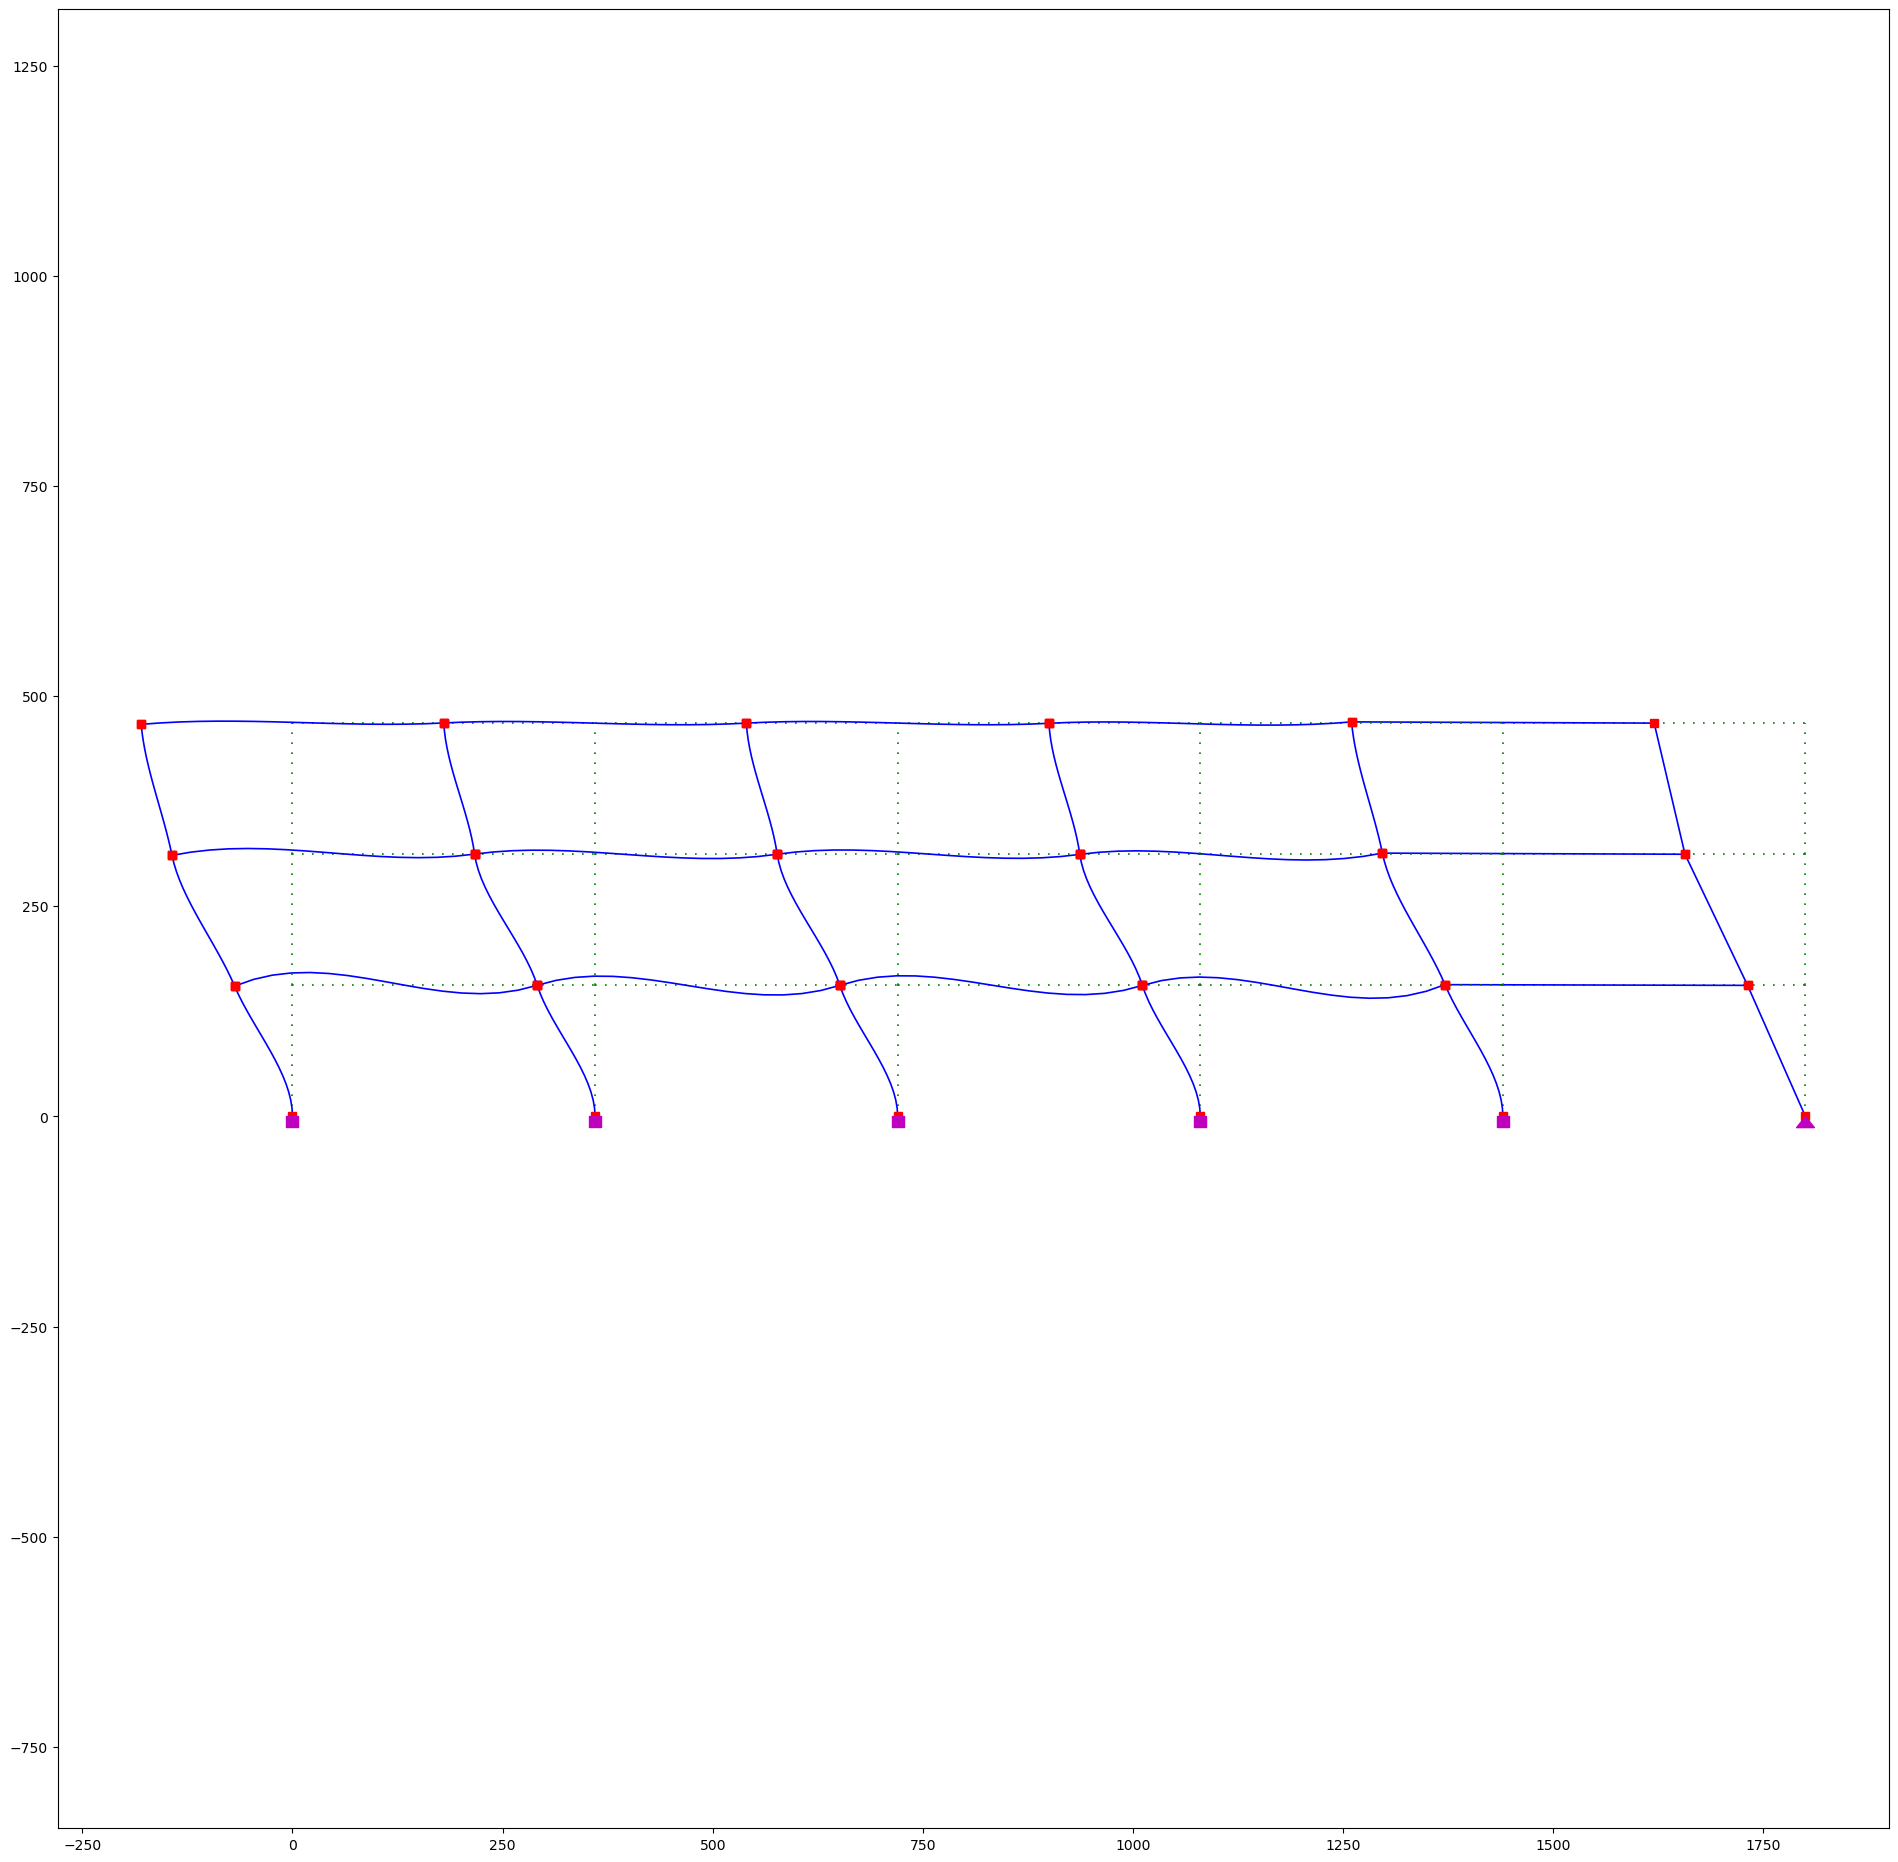

In [3]:
import opsvis as opsv
opsv.plot_mode_shape(1, sfac=False, nep=17, unDefoFlag=1, 
                       fmt_defo={'color': 'blue', 'linestyle': 'solid', 'linewidth': 1.2, 'marker': '', 'markersize': 1}, 
                       fmt_undefo={'color': 'green', 'linestyle': (0, (1, 5)), 'linewidth': 1.2, 'marker': '', 'markersize': 1}, 
                       fmt_defo_faces={'alpha': 0.5, 'edgecolors': 'k', 'linewidths': 1}, fmt_undefo_faces={'alpha': 0.5, 'edgecolors': 'g', 'facecolors': 'w', 'linestyles': 'dotted', 'linewidths': 1}, 
                       interpFlag=1, endDispFlag=1, fmt_nodes={'color': 'red', 'linestyle': 'None', 'linewidth': 1.2, 'marker': 's', 'markersize': 6}, 
                       Eo=0, az_el=(-60.0, 30.0), fig_wi_he=(60,60), fig_lbrt=False, node_supports=True, ax=False)

# Nonlinear Analysis

In [1]:
# Nonlinear Analysis
import pandas as pd
import pathlib
from BuildingObject import Building_object
# from help_functions import read_tworow_csv_file

cwdFile = pathlib.Path.cwd()
buildingDataFile = cwdFile / 'BuildingData'
geometryFile = buildingDataFile / 'Geometry.csv'
memberSizeFile = buildingDataFile / 'MemberSize.csv'
loadsFile = buildingDataFile / 'Loads.csv'

# geometry = read_tworow_csv_file(geometryFile)
# for key in geometry.keys():
#     geometry[key] = int(geometry[key])
member_size = pd.read_csv(memberSizeFile)
gravity_loads = pd.read_csv(loadsFile)
directory = {}
dir_ElasticModel = cwdFile / 'BuildingElasticModel'
dir_BaselineElasticModel = cwdFile / 'BaselineTclFiles' / 'ElasticAnalysis'
directory = {'building elastic model': dir_ElasticModel,
             'baseline files elastic': dir_BaselineElasticModel,
             'building data': buildingDataFile}

# elf
building = Building_object(directory, member_size, gravity_loads)

# beams
beamSizeFile = buildingDataFile / 'beamsectionsize.csv'
SectionDatabaseFile = cwdFile / 'AllSectionDatabase.csv'
SectionDatabase = pd.read_csv(SectionDatabaseFile)
from beam_component import Beam
from steel_material import SteelMaterial
steel = SteelMaterial(yield_stress=50, ultimate_stress=65, elastic_modulus=29000, 
                      Ry_value=1.1)  # Unit: ksi
# 创建包含梁信息的嵌套字典
beam_section_size = pd.read_csv(beamSizeFile)
beams = {}
length = int(building.geometry['X bay width'])
for _, row in beam_section_size.iterrows():
    level, bay = map(int, row[:2])
    bsection_size = {'size': row[2]}
    beams.setdefault(level, {})
    beams[level].setdefault(bay, {})
    beams[level][bay] = Beam(bsection_size['size'], length, steel,SectionDatabase)
    
# elastic demand
import pickle
elasticDemandFile = cwdFile / 'elastic_demand.pkl'
with open(elasticDemandFile, 'rb') as f:
    elastic_demand = pickle.load(f)

# column
columnSizeFile = buildingDataFile / 'columnsectionsize.csv'
SectionDatabaseFile = cwdFile / 'AllSectionDatabase.csv'
SectionDatabase = pd.read_csv(SectionDatabaseFile)
from column_component import Column
from steel_material import SteelMaterial
steel = SteelMaterial(yield_stress=50, ultimate_stress=65, elastic_modulus=29000, 
                      Ry_value=1.1)  # Unit: ksi

# 构建包含柱信息的嵌套字典
column_section_size = pd.read_csv(columnSizeFile)
columns = {}
for _, row in column_section_size.iterrows():
    story, pier = map(int, row[:2])
    csection_size = {'size': row[2]}
    columns.setdefault(story, {})
    columns[story].setdefault(bay, {})
    axial_demand = abs(elastic_demand.dominate_load['column axial'][story, 2 * pier])
    Lx = (building.geometry['floor height'][story+1] - building.geometry['floor height'][story]).item()
    Ly = Lx
    columns[story][pier] = Column(csection_size['size'], axial_demand, Lx, Ly, steel, SectionDatabase)

from nonlinear_analysis import NonlinearAnalysis
baseFile = cwdFile
U = NonlinearAnalysis(building, columns, beams, baseFile)

Variable defined!
Nodes for frame are defined!
Nodes for leaning column defined!
Extra nodes for leaning column springs defined!
All column base fixities are defined!
Floor constraints are defined!
Beam hinge materials defined!
Column hinge materials are defined!
Beams are defined!
Columns are defined!
Beam hinges are defined!
Column hinge are defined!
Nodal mass are defined!
Panel zone elements are defined!
6.5384590448019475 42.19147616072822
0.9609581193560732 0.14892072709766832
Expected gravity loads are defined!
Gravity Analysis Completed!
0.00681570382686104
Rayleigh damping defined!


Modified Ibarra-Medina-Krawinkler Model with Bilinear Hysteretic Response


Analysis Completed!


(83501,)
(83501,)


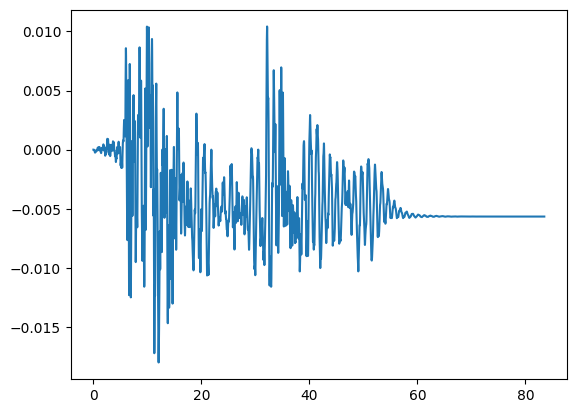

In [2]:
import matplotlib.pyplot as plt
import numpy as np
t = np.arange(0, 4175*0.02+0.001, 0.001)
# plt.plot(U)
print(t.shape)
print(U.shape)
plt.plot(t, U)

In [ ]:
import opsvis as opsv
opsv.plot_model(node_labels=0, element_labels=0, 
                offset_nd_label=False, axis_off=0, az_el=(-60.0, 30.0), 
                fig_wi_he=(60,60), fig_lbrt=False, local_axes=True, nodes_only=False, 
                fmt_model={'color': 'blue', 'linestyle': 'solid', 'linewidth': 1.2, 'marker': '.', 'markersize': 6}, 
                fmt_model_nodes_only={'color': 'blue', 'linestyle': 'solid', 'linewidth': 1.2, 'marker': '.', 'markersize': 6}, 
                node_supports=True, gauss_points=True, 
                fmt_gauss_points={'color': 'firebrick', 'linestyle': 'None', 'linewidth': 2.0, 'marker': 'X', 'markersize': 5}, 
                fmt_model_truss={'color': 'green', 'linestyle': 'solid', 'linewidth': 1.2, 'marker': 'o', 'markerfacecolor': 'white', 'markersize': 6}, 
                truss_node_offset=0.96, ax=False)

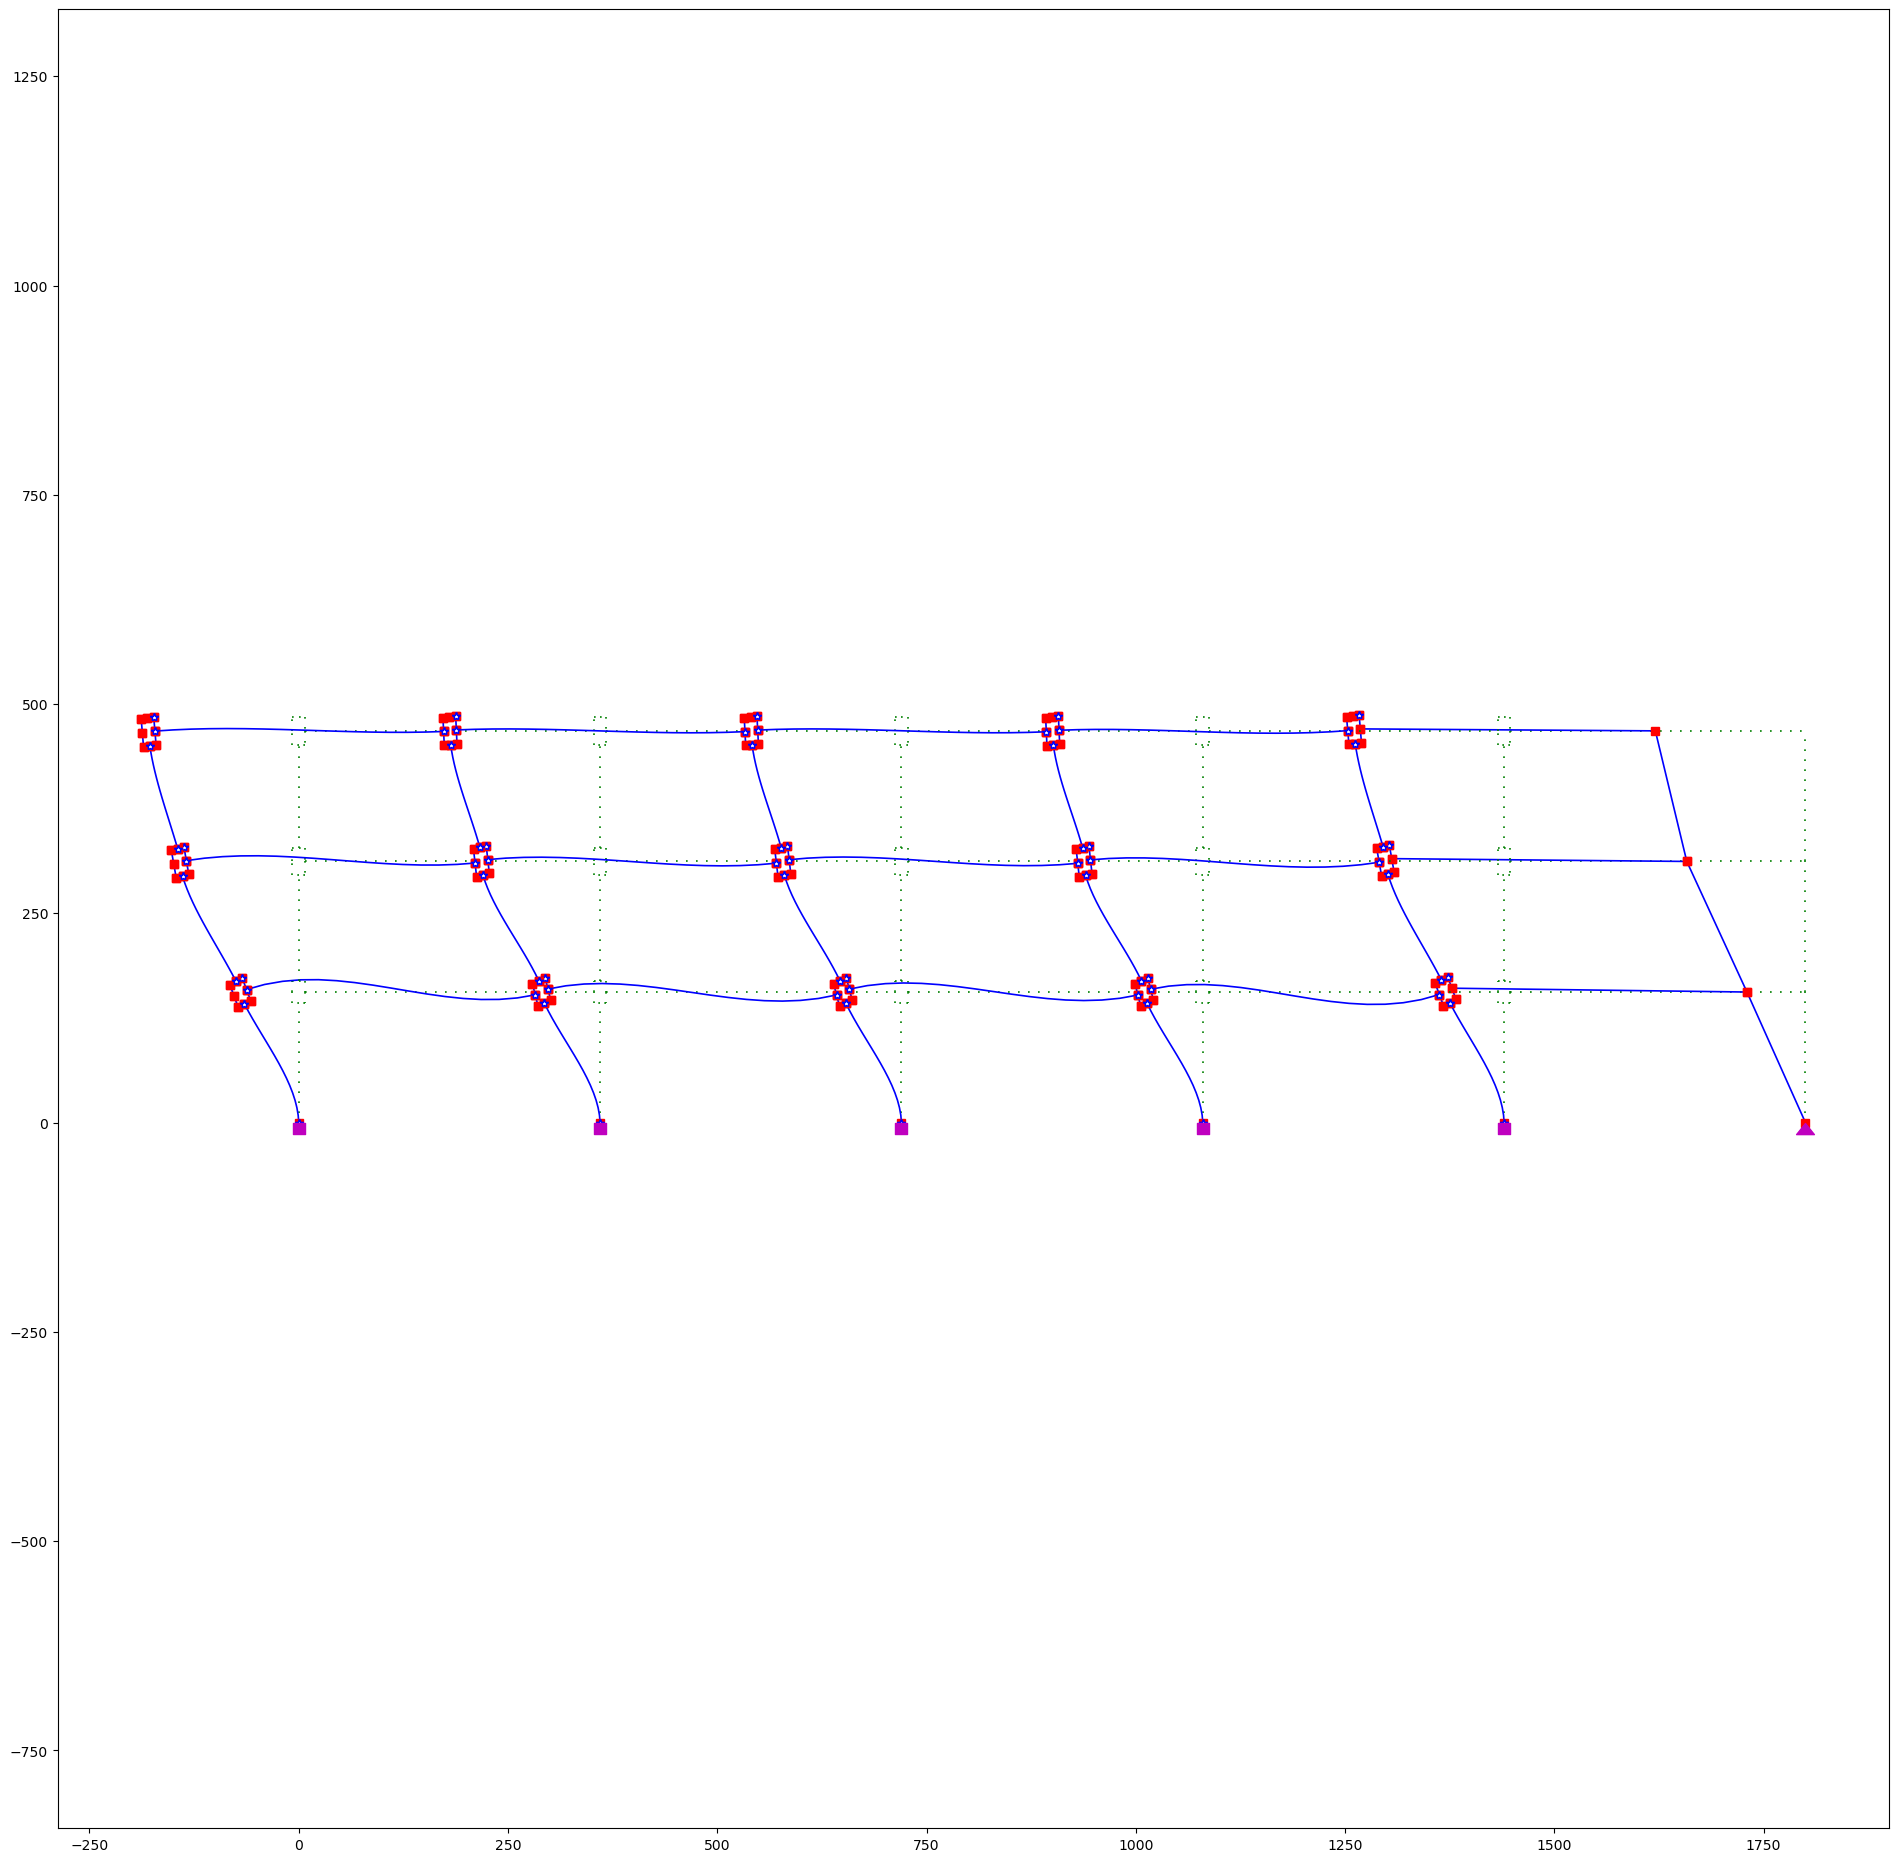

In [2]:
import opsvis as opsv
opsv.plot_mode_shape(1, sfac=False, nep=17, unDefoFlag=1, 
                       fmt_defo={'color': 'blue', 'linestyle': 'solid', 'linewidth': 1.2, 'marker': '', 'markersize': 1}, 
                       fmt_undefo={'color': 'green', 'linestyle': (0, (1, 5)), 'linewidth': 1.2, 'marker': '', 'markersize': 1}, 
                       fmt_defo_faces={'alpha': 0.5, 'edgecolors': 'k', 'linewidths': 1}, fmt_undefo_faces={'alpha': 0.5, 'edgecolors': 'g', 'facecolors': 'w', 'linestyles': 'dotted', 'linewidths': 1}, 
                       interpFlag=1, endDispFlag=1, fmt_nodes={'color': 'red', 'linestyle': 'None', 'linewidth': 1.2, 'marker': 's', 'markersize': 6}, 
                       Eo=0, az_el=(-60.0, 30.0), fig_wi_he=(60,60), fig_lbrt=False, node_supports=True, ax=False)

In [3]:
from Functions import NodesAroundPanelZone
NodesAroundPanelZone(1,1,0,0,[0,0],4,5)

In [1]:
import numpy as np
a = np.arange(0,13, 0.01)
a

array([0.000e+00, 1.000e-02, 2.000e-02, ..., 1.297e+01, 1.298e+01,
       1.299e+01])

<Axes: >

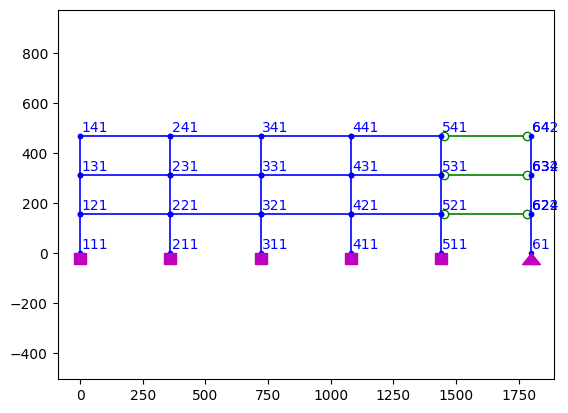

In [16]:
opsv.plot_model(node_labels=1, element_labels=0, offset_nd_label=False, axis_off=0, az_el=(-60.0, 30.0), fig_wi_he=False, fig_lbrt=False, local_axes=True, nodes_only=False, fmt_model={'color': 'blue', 'linestyle': 'solid', 'linewidth': 1.2, 'marker': '.', 'markersize': 6}, fmt_model_nodes_only={'color': 'blue', 'linestyle': 'solid', 'linewidth': 1.2, 'marker': '.', 'markersize': 6}, node_supports=True, gauss_points=True, fmt_gauss_points={'color': 'firebrick', 'linestyle': 'None', 'linewidth': 2.0, 'marker': 'X', 'markersize': 5}, fmt_model_truss={'color': 'green', 'linestyle': 'solid', 'linewidth': 1.2, 'marker': 'o', 'markerfacecolor': 'white', 'markersize': 6}, truss_node_offset=0.96, ax=False)

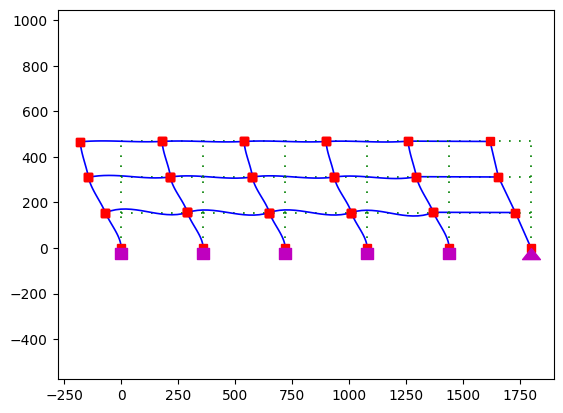

In [14]:
opsv.plot_mode_shape(1, sfac=False, nep=17, unDefoFlag=1, 
                       fmt_defo={'color': 'blue', 'linestyle': 'solid', 'linewidth': 1.2, 'marker': '', 'markersize': 1}, 
                       fmt_undefo={'color': 'green', 'linestyle': (0, (1, 5)), 'linewidth': 1.2, 'marker': '', 'markersize': 1}, 
                       fmt_defo_faces={'alpha': 0.5, 'edgecolors': 'k', 'linewidths': 1}, fmt_undefo_faces={'alpha': 0.5, 'edgecolors': 'g', 'facecolors': 'w', 'linestyles': 'dotted', 'linewidths': 1}, 
                       interpFlag=1, endDispFlag=1, fmt_nodes={'color': 'red', 'linestyle': 'None', 'linewidth': 1.2, 'marker': 's', 'markersize': 6}, Eo=0, az_el=(-60.0, 30.0), fig_wi_he=False, 
                       fig_lbrt=False, node_supports=True, ax=False)

In [3]:
ops.wipe()
ops.model('basic', '-ndm', 2, '-ndf', 3)
createnodes(13)
ops.getNodeTags()

[13, 14]

In [1]:
import numpy as np
from createnodes import *
a = np.zeros([2, 2, 2])
a[0, 0, :] = [1, 2]
b = a[0, 0, :]
c = test(b)
c

1.0


array([1., 2.])

In [13]:
b = 10
a = '%i%s' % (b,'01')
a = int(a)
a

1001

In [4]:
import numpy as np
a = np.zeros([9])
a

array([0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [6]:
import pandas as pd
df = pd.read_csv(r'C:\Users\12734\OneDrive\重要文件\可参考文件\AutoSDAPlatform-master\AutoSDAPlatform-master\AllSectionDatabase.csv')
df

,index,section size,weight,A,d,bf,tw,tf,bf to tf ratio,h to tw ratio,...,Zx,Sx,rx,Iy,Zy,Sy,ry,J,Cw,rts
0,0,W36X652,652,192.00,41.1,17.60,1.970,3.540,2.48,16.3,...,2910.0,2460.0,16.20,3230.00,581.00,367.00,4.100,593.000,1130000,4.96
1,1,W36X529,529,156.00,39.8,17.20,1.610,2.910,2.96,19.9,...,2330.0,1990.0,16.00,2490.00,454.00,289.00,4.000,327.000,846000,4.80
2,2,W36X487,487,143.00,39.3,17.10,1.500,2.680,3.19,21.4,...,2130.0,1830.0,15.80,2250.00,412.00,263.00,3.960,258.000,754000,4.74
3,3,W36X441,441,130.00,38.9,17.00,1.360,2.440,3.48,23.6,...,1910.0,1650.0,15.70,1990.00,368.00,235.00,3.920,194.000,661000,4.69
4,4,W36X395,395,116.00,38.4,16.80,1.220,2.200,3.83,26.3,...,1710.0,1490.0,15.70,1750.00,325.00,208.00,3.880,142.000,575000,4.61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,165,W12X45,45,13.10,12.1,8.05,0.335,0.575,7.00,29.6,...,64.2,57.7,5.15,50.00,19.00,12.40,1.950,1.260,1650,2.23
166,166,W12X35,35,10.30,12.5,6.56,0.300,0.520,6.31,36.2,...,51.2,45.6,5.25,24.50,11.50,7.47,1.540,0.741,879,1.79
167,167,W14X26,26,7.69,13.9,5.03,0.255,0.420,5.98,48.1,...,40.2,35.3,5.65,8.91,5.54,3.55,1.080,0.358,405,1.30
168,168,W12X22,22,6.48,12.3,4.03,0.260,0.425,4.74,41.8,...,29.3,25.4,4.91,4.66,3.66,2.31,0.848,0.293,164,1.04


In [8]:
from Functions import SectionProperty
section_info = SectionProperty('W14X500', df)
section_info

{'index': 55,
 'section size': 'W14X500',
 'weight': 500,
 'A': 147.0,
 'd': 19.6,
 'bf': 17.0,
 'tw': 2.19,
 'tf': 3.5,
 'bf to tf ratio': 2.43,
 'h to tw ratio': 5.21,
 'Ix': 8210,
 'Zx': 1050.0,
 'Sx': 838.0,
 'rx': 7.48,
 'Iy': 2880.0,
 'Zy': 522.0,
 'Sy': 339.0,
 'ry': 4.43,
 'J': 514.0,
 'Cw': 187000,
 'rts': 5.26}

In [9]:
section_info['A']

147.0

1001